In [1]:
import read_write_model as colmap_reader
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from datautils import read_data
from nerfhelpers import get_rays, batched_get_rays, NeRF, run_model
import time
import cv2
from tqdm.notebook import tqdm
%load_ext autoreload
%autoreload 2

In [2]:
imagedir = '../Bulldozer'
camFile = '../Bulldozer/cameras.bin'
imgFile = '../Bulldozer/images.bin'

t = time.time()
torch.set_default_dtype(torch.float32) 
images, c2w, W, H, F = read_data(camFile, imgFile, imagedir)
images = torch.tensor(images, dtype = torch.float32)[:10]#.view(10, -1, 3)
c2w = torch.tensor(c2w, dtype = torch.float32)[:10]
print(f"Time taken to read images and poses: {time.time() - t:.2f}s")

gpu = torch.device('cuda')
cpu = torch.device('cpu')

Loading Poses...
Done
Reading Images...
Done
Time taken to read images and poses: 1.58s


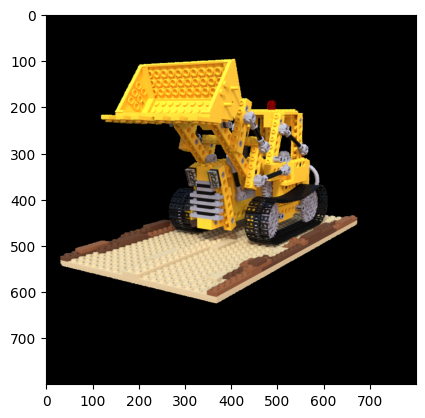

In [3]:
plt.imshow(cv2.cvtColor(images[5].numpy().astype(np.float32), cv2.COLOR_BGR2RGB))

In [7]:
images.shape

torch.Size([10, 800, 800, 3])

In [11]:
rays_o, rays_d = get_rays(H, W, F, c2w[0])
rgb, depth, acc = run_model(ray_start, ray_stop, N_samples, model, rays_o, rays_d, use_chunks = False)


KeyboardInterrupt



  0%|          | 0/25 [00:00<?, ?it/s]

Total time taken: 34.06
Loss: 56.32636


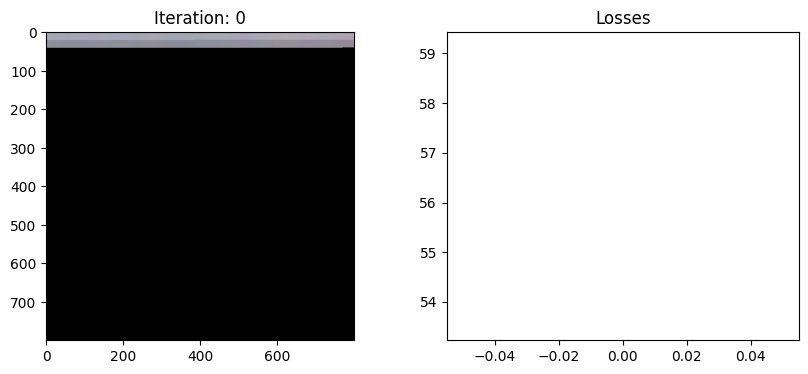

Total time taken: 34.00
Loss: 47.36068


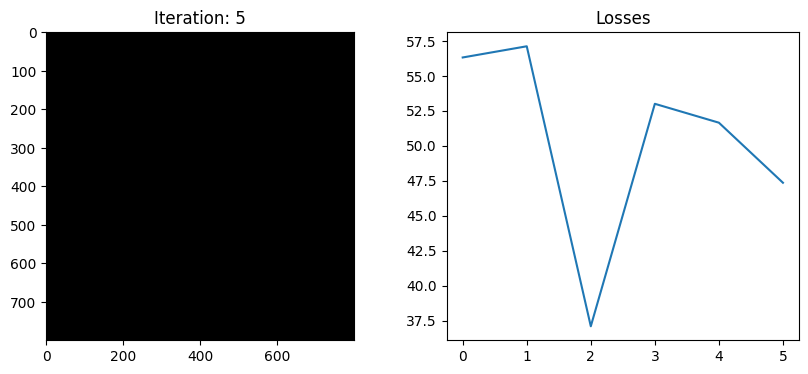

Total time taken: 34.71
Loss: 34.55452


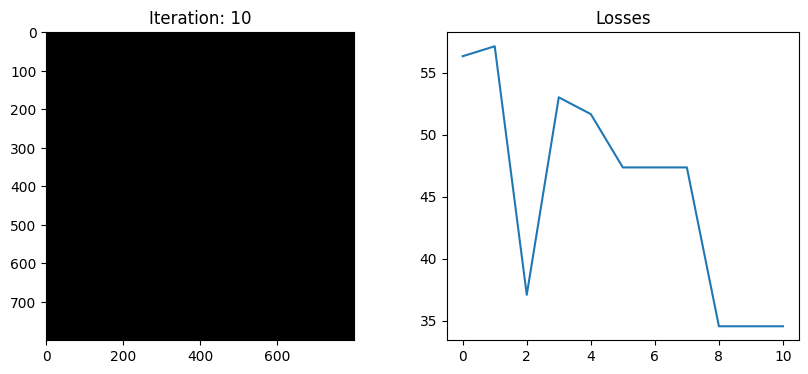

Total time taken: 34.79
Loss: 32.12654


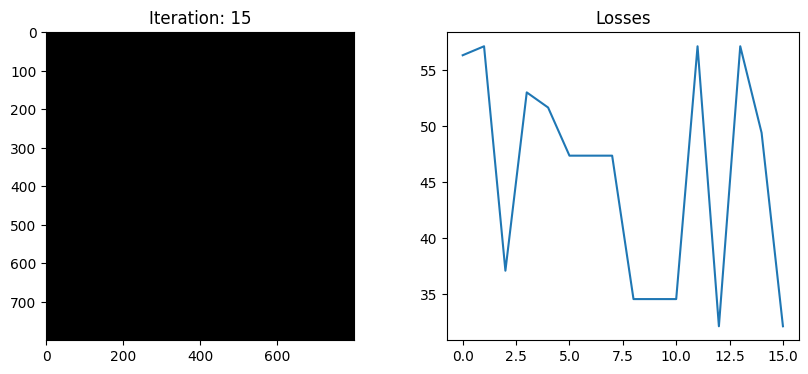

Total time taken: 34.33
Loss: 57.12751


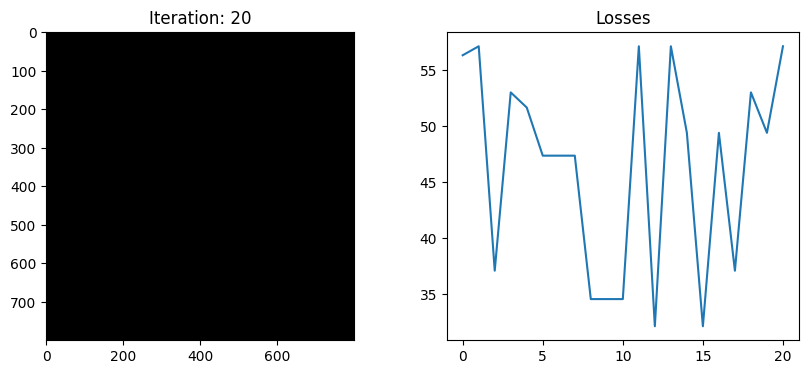

Total time taken: 34.77
Loss: 32.12654


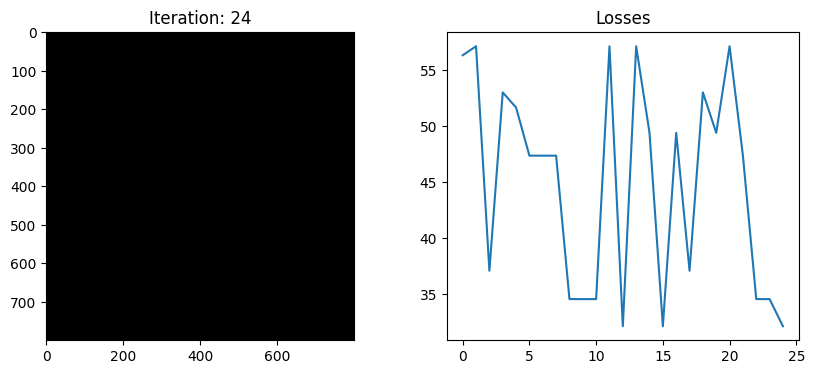

In [4]:
torch.autograd.set_detect_anomaly(True)

N_iters = 25
N_samples = 64

batch_size = 4096*4
report_interval = 10

L_pos = 10
L_dir = 6

ray_start = 0
ray_stop = 10

lr_decay_stop = 1000
lr_decay_target = 5e-5

lr = 5e-4

losses = []
all_losses = []

model = NeRF(L_pos, L_dir, gpu)
optimizer = torch.optim.Adam(model.parameters(), lr = lr, eps = 1e-7)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, (lr - lr_decay_target) / lr_decay_stop, -1)


for N in tqdm(range(N_iters)):
    t = time.time()
    i = np.random.randint(0, images.shape[0])
    image = images[i].reshape(-1, 3)

    #rt = time.time()
    rays_o, rays_d = get_rays(H, W, F, c2w[i])
    rays_o = rays_o.view(-1, 3)
    rays_d = rays_d.view(-1, 3)
    #print(f"Time taken to get rays: {time.time() - rt}")

    rgb = None
    alpha = None

    rgbs = []

    losses = []
    for i in range(0, H*W, batch_size):
        stop = batch_size
        if i + stop >= H*W:
            stop = H*W
        mt = time.time()
        rgb, depth, acc = run_model(ray_start, ray_stop, N_samples, model, rays_o[i:i+stop, :], rays_d[i:i+stop, :], use_chunks = False)
        #print(f'Iter {i // batch_size} taken to render: {time.time() - mt:.2f}')
        if N % report_interval == 0 or N == N_iters - 1:
            rgbs.append(rgb)
        
        loss = torch.linalg.norm(rgb - image[i:i+stop])
        losses.append(loss.detach().item())
        #print(f'Loss: {loss:.2f}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    all_losses.append(np.mean(losses))

    #print("Done processing model outputs")

    if N < lr_decay_stop:
        scheduler.step()

    if N % report_interval == 0 or N == N_iters - 1:
        rgb = torch.cat(rgbs, 0)
        print(f'Total time taken: {time.time() - t:.2f}')
        print(f'Loss: {np.mean(losses):.5f}')
        plt.figure(figsize = (10, 4))
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(rgb.detach().numpy().reshape(H, W, 3).astype(np.float32), cv2.COLOR_BGR2RGB))
        plt.title(f'Iteration: {N}')
        plt.subplot(122)
        plt.plot(all_losses)
        plt.title("Losses")
        plt.show()


In [6]:
rgb.mean()

tensor(0., grad_fn=<MeanBackward0>)

In [9]:
losses

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 46.38690948486328,
 44.843711853027344,
 42.55915069580078,
 42.59555435180664,
 44.91799545288086,
 37.38941955566406,
 57.338844299316406,
 59.33390808105469,
 41.62246322631836,
 33.65699768066406,
 33.61730194091797,
 37.9188232421875,
 49.724388122558594,
 51.791622161865234,
 49.0628776550293,
 50.77988815307617,
 48.314876556396484,
 41.932254791259766,
 43.037200927734375,
 41.952293395996094,
 40.277469635009766,
 29.543922424316406,
 40.89613723754883,
 62.833465576171875,
 77.36882781982422,
 83.2221908569336,
 52.14303207397461,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
#old: 717

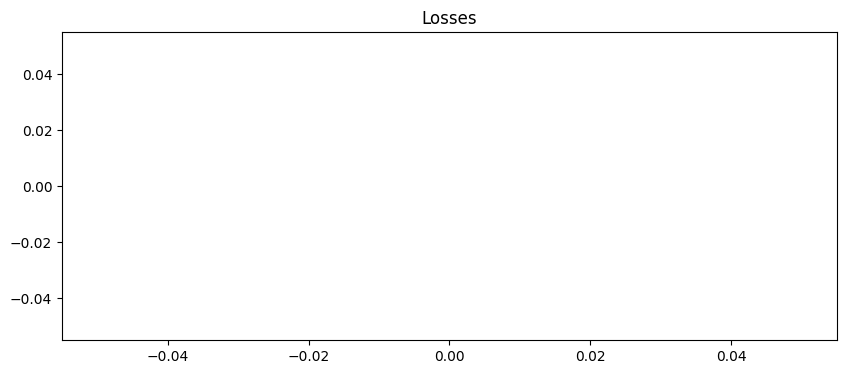

In [4]:
plt.figure(figsize = (10, 4))
plt.plot(losses)
plt.title("Losses")
plt.show()